*Modified from [https://blog.csdn.net/Teeyohuang/article/details/79210525](https://blog.csdn.net/Teeyohuang/article/details/79210525).*

## 这些是要用到的东西

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

## 下载并加载数据

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## 看看 `trainset`

In [3]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

## 看看 `testset`

In [4]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

## 总共有这么几类

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## 取几张图片出来看看

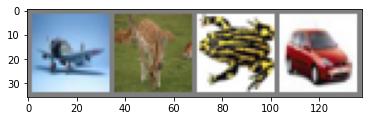

plane  deer  frog   car


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join("%5s" % classes[labels[i]] for i in range(4)))

## 定义卷积神经网络 `Net`

In [7]:
class Net(nn.Module):                 # 我们定义网络时一般是继承的torch.nn.Module创建新的子类
    def __init__(self):    
        super(Net, self).__init__()   # 第二、三行都是python类继承的基本操作,此写法应该是python2.7的继承格式,但python3里写这个好像也可以
        self.conv1 = nn.Conv2d(3, 6, 5)       # 添加第一个卷积层,调用了nn里面的Conv2d（）
        self.pool = nn.MaxPool2d(2, 2)        # 最大池化层
        self.conv2 = nn.Conv2d(6, 16, 5)      # 同样是卷积层
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 接着三个全连接层
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
 
    def forward(self, x):                  # 这里定义前向传播的方法，为什么没有定义反向传播的方法呢？这其实就涉及到torch.autograd模块了，
                                           # 但说实话这部分网络定义的部分还没有用到autograd的知识，所以后面遇到了再讲
        x = self.pool(F.relu(self.conv1(x)))  # F是torch.nn.functional的别名，这里调用了relu函数 F.relu()
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)  # .view( )是一个tensor的方法，使得tensor改变size但是元素的总数是不变的。
                                    #  第一个参数-1是说这个参数由另一个参数确定， 比如矩阵在元素总数一定的情况下，确定列数就能确定行数。
                                    #  那么为什么这里只关心列数不关心行数呢，因为马上就要进入全连接层了，而全连接层说白了就是矩阵乘法，
                                    #  你会发现第一个全连接层的首参数是16*5*5，所以要保证能够相乘，在矩阵乘法之前就要把x调到正确的size
                                    # 更多的Tensor方法参考Tensor: http://pytorch.org/docs/0.3.0/tensors.html
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 实例化一张叫做 `net` 的 `Net`

In [8]:
net = Net()

## 看看能不能用 CUDA

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 定义损失函数和优化器

In [10]:
criterion = nn.CrossEntropyLoss()    #同样是用到了神经网络工具箱 nn 中的交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)   #optim模块中的SGD梯度优化方式---随机梯度下降

## 把 `net` 弄到 CUDA 上（如果是 CUDA 的话）

In [11]:
net = net.to(device)

## 学习

In [12]:
for epoch in range(2):  # loop over the dataset multiple times 指定训练一共要循环几个epoch
 
    running_loss = 0.0  #定义一个变量方便我们对loss进行输出
    for i, data in enumerate(trainloader, 0): # 这里我们遇到了第一步中出现的trailoader，代码传入数据
                                              # enumerate是python的内置函数，既获得索引也获得数据，详见下文
        # get the inputs
        inputs, labels = data   # data是从enumerate返回的data，包含数据和标签信息，分别赋值给inputs和labels
        inputs, labels = inputs.to(device), labels.to(device)
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels) # 将数据转换成Variable，第二步里面我们已经引入这个模块
                                                            # 所以这段程序里面就直接使用了，下文会分析
        # zero the parameter gradients
        optimizer.zero_grad()                # 要把梯度重新归零，因为反向传播过程中梯度会累加上一次循环的梯度
 
        # forward + backward + optimize      
        outputs = net(inputs)                # 把数据输进网络net，这个net()在第二步的代码最后一行我们已经定义了
        loss = criterion(outputs, labels)    # 计算损失值,criterion我们在第三步里面定义了
        loss.backward()                      # loss进行反向传播，下文详解
        optimizer.step()                     # 当执行反向传播之后，把优化器的参数进行更新，以便进行下一轮
 
        # print statistics                   # 这几行代码不是必须的，为了打印出loss方便我们看而已，不影响训练过程
        running_loss += loss.item()         # 从下面一行代码可以看出它是每循环0-1999共两千次才打印一次
        if i % 2000 == 1999:    # print every 2000 mini-batches   所以每个2000次之类先用running_loss进行累加
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))  # 然后再除以2000，就得到这两千次的平均损失值
            running_loss = 0.0               # 这一个2000次结束后，就把running_loss归零，下一个2000次继续使用
            
print('Finished Training')

C:\ProgramData\Anaconda3\envs\herkules-ai\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.232
[1,  4000] loss: 1.862
[1,  6000] loss: 1.675
[1,  8000] loss: 1.565
[1, 10000] loss: 1.530
[1, 12000] loss: 1.472
[2,  2000] loss: 1.408
[2,  4000] loss: 1.380
[2,  6000] loss: 1.367
[2,  8000] loss: 1.337
[2, 10000] loss: 1.316
[2, 12000] loss: 1.283
Finished Training


## 挑几张图片出来看看效果

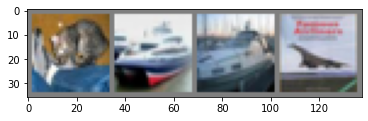

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car plane


In [13]:
dataiter = iter(testloader)      # 创建一个python迭代器，读入的是我们第一步里面就已经加载好的testloader
images, labels = dataiter.next() # 返回一个batch_size的图片，根据第一步的设置，应该是4张
 
# print images
imshow(torchvision.utils.make_grid(images))  # 展示这四张图片
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4))) # python字符串格式化 ' '.join表示用空格来连接后面的字符串，参考python的join（）方法

images = images.to(device)

outputs = net(Variable(images))      # 注意这里的images是我们从上面获得的那四张图片，所以首先要转化成variable
_, predicted = torch.max(outputs.data, 1)  
                # 这个 _ , predicted是python的一种常用的写法，表示后面的函数其实会返回两个值
                # 但是我们对第一个值不感兴趣，就写个_在那里，把它赋值给_就好，我们只关心第二个值predicted
                # 比如 _ ,a = 1,2 这中赋值语句在python中是可以通过的，你只关心后面的等式中的第二个位置的值是多少

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))  # python的字符串格式化

## 测试总体正确率

In [14]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
for data in testloader:  # 循环每一个batch
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = net(Variable(images))  # 输入网络进行测试
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)          # 更新测试图片的数量
    correct += (predicted == labels).sum() # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))          # 最后打印结果

Accuracy of the network on the 10000 test images: 56 %


## 测试每一类正确率

In [15]:
class_correct = list(0. for i in range(10)) # 定义一个存储每类中测试正确的个数的 列表，初始化为0
class_total = list(0. for i in range(10))   # 定义一个存储每类中测试总数的个数的 列表，初始化为0
for data in testloader:     # 以一个batch为单位进行循环
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
        label = labels[i]   # 对各个类的进行各自累加
        class_correct[label] += c[i]
        class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 68 %
Accuracy of  bird : 41 %
Accuracy of   cat : 43 %
Accuracy of  deer : 46 %
Accuracy of   dog : 39 %
Accuracy of  frog : 66 %
Accuracy of horse : 57 %
Accuracy of  ship : 65 %
Accuracy of truck : 68 %
